In [1]:
NAME = "Alasdair Breasley"
CIS_USERNAME = "fmcv76"

---

# COMP42415 Text Mining and Language Analytics
## Coursework 2023-24

### Instructions:

- <ins>**DO NOT RENAME THIS JUPYTER NOTEBOOK !!!**</ins>
- Please write the answers for each question in the respective cell. 
- You can add more cells if needed.
- If needed, you can upload additional files, e.g. pre-trained word embeddings, in the coursework's directory
- You can safely remove the `raise NotImplementedError()` line from each code cell.
- You can find information about markdown syntax from [here](https://www.markdownguide.org/basic-syntax/#emphasis).

In [2]:
# Import required packages 
import numpy as np
import pandas as pd
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer
nltk.download("averaged_perceptron_tagger")
from nltk import pos_tag
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score,precision_score, recall_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
sns.set() # Use seaborn plotting style
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


<ipython-input-2-93956035a2ad>:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package stopwords to
[nltk_data]     /home3/fmcv76/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home3/fmcv76/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home3/fmcv76/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home3/fmcv76/nltk_data...
[nltk_data]   Package averaged_perc

## Implementation - Task 1
Prepare the dataset by applying any pre-processing or cleaning steps that you consider as necessary. Then, split the dataset into a training set containing 70% of the samples and a test set containing 30% of the samples. Follow an appropriate strategy for the split. You must use these training/test sets for all the models in this coursework. (**10%**)

In [3]:
# Import food reviews data 
food_reviews_data = pd.read_csv("food_reviews.csv")

# Check dataframe head 
print(food_reviews_data.head(5), "\n")

# Check dataframe shape 
print(food_reviews_data.shape, "\n")

# Check data types 
print(food_reviews_data.dtypes, "\n")

# Check uniqueness of Score column 
print(food_reviews_data["Score"].unique(), "\n")

# Check for duplicate rows 
print(food_reviews_data[food_reviews_data.duplicated()].shape[0], "\n")

# Remove duplicate rows 
food_reviews_data = food_reviews_data.drop_duplicates()

# Recheck dataframe shape 
print(food_reviews_data.shape, "\n")

# Concatinate Summary column with Text column to capture all available information 
food_reviews_data["Text"] = food_reviews_data["Summary"].astype(str) + " " + food_reviews_data["Text"].astype(str)

# TODO: Decide if adding both columns together makes sense 

# Check how many rows contain html tags 
print(food_reviews_data["Text"].str.contains(r"<.+?>").sum(), "\n")

# Replace html tags with " ", " " as opposed to "" to not join words unintentionally 
food_reviews_data["Text"] = food_reviews_data["Text"].str.replace(r"<.+?>", " ", regex = True)

# Recheck how many rows contain html tags 
print(food_reviews_data["Text"].str.contains(r"<.+?>").sum(), "\n")

# Transform Text column to all lowercase 
food_reviews_data["Text"] = food_reviews_data["Text"].str.lower()

# Check how many rows include punctuation 
print(food_reviews_data["Text"].str.contains(r"[^\w\s]").sum(), "\n")

# TODO: Decide if "'" should be removed at this point or if some of the later steps can handle don't etc. 

# Remove punctuation 
food_reviews_data["Text"] = food_reviews_data["Text"].str.replace(r"[^\w\s]", " ", regex = True)

# Recheck how many rows include punctuation 
print(food_reviews_data["Text"].str.contains(r"[^\w\s]").sum(), "\n")

# Check for class imbalance 
print(food_reviews_data["Score"].value_counts(), "\n")

# There is class imbalance present 

# Check dataframe head 
print(food_reviews_data.head(5), "\n")


   Score                                           Summary  \
0      5                                      three cheese   
1      5                        Coffee  ***UPDATE*** added   
2      5                    Delicious cocoa for grown ups!   
3      5  Really Good Fresh Murray's Sugar-Free Shortbread   
4      3                                         OK Coffee   

                                                Text  
0  really good three cheese potatoes great with h...  
1  I love coffee, and a particular fantasy of min...  
2  This is not sugary sweet hot chocolate, nor is...  
3  These cookies arrived quickly and are in great...  
4  This is decent coffee. Nothing special. It is ...   

(540031, 3) 

Score       int64
Summary    object
Text       object
dtype: object 

[5 3 1 4 2] 

162009 

(378022, 3) 

99031 

0 

377189 

0 

Score
5    240802
4     53798
1     34923
3     28580
2     19919
Name: count, dtype: int64 

   Score                                           Summ

In [4]:
# Temporarily reduce dataframe size for developement 
food_reviews_data = food_reviews_data[0:5000]

# Check for class imbalance 
print(food_reviews_data["Score"].value_counts())

# There is class imbalance present 


Score
5    3204
4     728
1     469
3     348
2     251
Name: count, dtype: int64


In [5]:
def penn_to_wordnet(penn_pos_tag):
    """Function to convert Penn Treeback POS tags to WordNet"""
    
    tag_dictionary = {"NN":"n", "JJ":"a","VB":"v", "RB":"r"}
    
    try:
        
        # If the first two characters of the Penn Treebank POS tag are in the tag_dictionary 
        return tag_dictionary[penn_pos_tag[:2]]
    
    except:
        
        return "n" # Default to Noun if no mapping avalable.
    

# Get list of English stop words 
stopwords_english = stopwords.words("english")

def remove_stopwords_and_lemmatise(text):
    """Function to tokenise a string, remove stop words, lemmatise, and concatinate back together."""
    
    # Tokenise text into words 
    words = word_tokenize(text)
    
    # Remove stop words 
    words_filtered = [word for word in words if word not in stopwords_english]
    
    # TODO: Update to use full conversion table as opposed to simplified version 
    
    # Apply POS tagging 
    words_pos_tagged = pos_tag(words_filtered)
    
    # Create a WordNetLemmatizer object 
    wnl = WordNetLemmatizer()
    
    # Define empty lemmas list 
    lemmas = []
    
    # Loop through words in sentence and lemmatise 
    for word, tag in words_pos_tagged:
    
        lemmas.append(wnl.lemmatize(word, pos = penn_to_wordnet(tag)))
    
    # Concatinate remaining words back into a string 
    return " ".join(lemmas)


# Remove stop words from Text column 
food_reviews_data["Text"] = food_reviews_data["Text"].apply(remove_stopwords_and_lemmatise)


In [6]:
# Split data into training (70%) and test (30%) splits 
train_data, test_data, train_labels, test_labels = train_test_split(food_reviews_data["Text"], food_reviews_data["Score"], 
                                                                    test_size = 0.3, random_state = 123, 
                                                                    stratify = food_reviews_data["Score"])

# TODO: Decide if it should be stratified random sampling or random sampling 


## Implementation - Task 2
Implement a Naïve Bayes model for predicting the rating of a food review. Train your model on the training set and test it on the test set. Use an appropriate text representation. (**5%**)

In [7]:
# Naive Bayes model - input is converted to TF-IDF vectors and then Multinomial Naive Bayes is used 
nb_model = make_pipeline(TfidfVectorizer(), MultinomialNB())

# Train model 
nb_model.fit(train_data, train_labels)

# Test model 
nb_predictions = nb_model.predict(test_data)


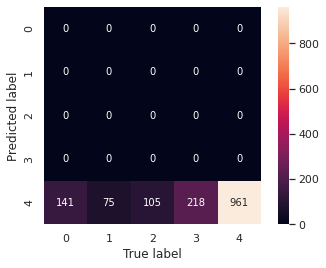

Accuracy:	0.640667
F1-score:	0.156197
Precision:	0.128133
Recall:		0.200000

Classification performance:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       141
           2       0.00      0.00      0.00        75
           3       0.00      0.00      0.00       105
           4       0.00      0.00      0.00       218
           5       0.64      1.00      0.78       961

    accuracy                           0.64      1500
   macro avg       0.13      0.20      0.16      1500
weighted avg       0.41      0.64      0.50      1500



/apps/jupyterhub/COMP42415/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/apps/jupyterhub/COMP42415/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/apps/jupyterhub/COMP42415/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/

In [8]:
# Plot the confusion matrix
matrix = confusion_matrix(test_labels, nb_predictions)
sns.heatmap(matrix.T, square = True, annot = True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_labels, nb_predictions))
print("F1-score:\t%f" % f1_score(test_labels, nb_predictions, average = "macro"))
print("Precision:\t%f" % precision_score(test_labels, nb_predictions, average = "macro"))
print("Recall:\t\t%f" % recall_score(test_labels, nb_predictions, average = "macro"))
print("\nClassification performance:\n%s" % classification_report(test_labels, nb_predictions))


## Implementation - Task 3
Implement a k-Nearest Neighbours model for predicting the rating of a food review. Train your model on the training set and test it on the test set. Use an appropriate text representation. You must select the best k by examining the performance of the model for $k \in \{1,3,5,7\}$, using an appropriate cross-validation approach. Create a plot for k vs. classification performance to justify your choice. (**10%**)

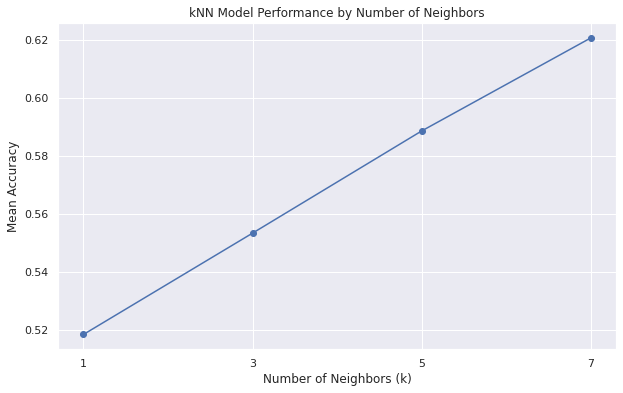

In [9]:
# Values of k to test 
k_values = [1, 3, 5, 7]

mean_accuracies = []

for k in k_values:
    
    knn_model = make_pipeline(TfidfVectorizer(), KNeighborsClassifier(n_neighbors=k))
    
    scores = cross_val_score(knn_model, train_data, train_labels, cv = 5, scoring = "accuracy")
    
    mean_accuracy = scores.mean()
    
    mean_accuracies.append(mean_accuracy)
    
plt.figure(figsize = (10, 6))
plt.plot(k_values, mean_accuracies, marker = "o", linestyle = "-", color = "b")
plt.title("kNN Model Performance by Number of Neighbors")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Mean Accuracy")
plt.xticks(k_values)
plt.grid(True)
plt.show()


In [10]:
# k Nearest Neighbour model - input is converted to TF-IDF vectors and then kNN is used 
# The k value which produced the hgihest accuracy from cross-validation on the train/validation set is used 
knn_model = make_pipeline(TfidfVectorizer(), KNeighborsClassifier(n_neighbors = k_values[mean_accuracies.index(max(mean_accuracies))]))

# Train model 
knn_model.fit(train_data, train_labels)

# Test model 
knn_predictions = knn_model.predict(test_data)


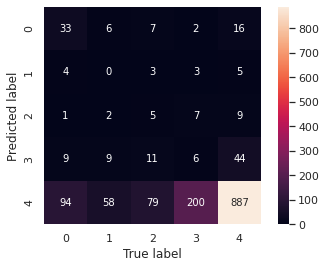

Accuracy:	0.620667
F1-score:	0.243657
Precision:	0.294579
Recall:		0.246436

Classification performance:
              precision    recall  f1-score   support

           1       0.52      0.23      0.32       141
           2       0.00      0.00      0.00        75
           3       0.21      0.05      0.08       105
           4       0.08      0.03      0.04       218
           5       0.67      0.92      0.78       961

    accuracy                           0.62      1500
   macro avg       0.29      0.25      0.24      1500
weighted avg       0.51      0.62      0.54      1500



In [11]:
# Plot the confusion matrix
matrix = confusion_matrix(test_labels, knn_predictions)
sns.heatmap(matrix.T, square = True, annot = True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_labels, knn_predictions))
print("F1-score:\t%f" % f1_score(test_labels, knn_predictions, average = "macro"))
print("Precision:\t%f" % precision_score(test_labels, knn_predictions, average = "macro"))
print("Recall:\t\t%f" % recall_score(test_labels, knn_predictions, average = "macro"))
print("\nClassification performance:\n%s" % classification_report(test_labels, knn_predictions))


## Implementation - Task 4
Implement a Convolutional Neural Network (CNN) model for predicting the rating of a food review. The model must have at least two convolutional layers. Train your model on the training set and test it on the test set. Use an appropriate text representation. (**13%**)

## Implementation - Task 5
Implement a Recurrent Neural Network (RNN) or a Long Short-Term Memory (LSTM) model for predicting the rating of a food review. The model must have at least two RNN/LSTM layers. Train your model on the training set and test it on the test set. Use an appropriate text representation. (**12%**)

## Implementation - Task 6
Compute the confusion matrix, accuracy, F1-score, precision and recall for each model. (10%)

## Implementation - Task 7
Store the **four** trained models in files and implement a function `predict_food_review(text, model)` that given a <ins>text string</ins> (“`text`”) and model <ins>filename</ins> (“`model`”), it will load the pre-trained model, and predict the food review rating of the input text. The function should be able to work without requiring to rerun all or part of your code. (**10%**)

## Report - Task 1
Critical discussion about the dataset (suitability, problems, class balance, etc.). (**6%**)

YOUR ANSWER HERE

## Report - Task 2
Description and justification of the data preparation step(s) used. (**6%**)

YOUR ANSWER HERE

## Report - Task 3
Description and commentary on the machine learning architectures used, including a description and justification of the text representation method(s) used. (**7%**)

YOUR ANSWER HERE

## Report - Task 4
Detailed performance evaluation of the trained machine learning models in terms of the computed performance metrics. (**5%**)

YOUR ANSWER HERE

## Report - Task 5
Critical discussion on the achieved results, including potential limitations and usage instructions/suggestions. (**6%**)

YOUR ANSWER HERE